# Import các thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module
import torch.optim as optim


# Import dữ liệu và tiền xử lý

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/NVL Historical Data 1_6.csv')

# Nhận thấy tập dữ liệu, ở cột Price giá tiền có dấu phẩy và đang ở dạng string
# Bỏ dấu phẩy
df['Price'] = df['Price'].str.replace(',', '')
# Chuyển sang dạng số
df['Price'] = pd.to_numeric(df['Price'])
df = df[::-1]

In [3]:
df1=df.reset_index()['Price']
df1.head()

0    27815
1    28410
2    28707
3    28962
4    29556
Name: Price, dtype: int64

In [4]:
df1

0       27815
1       28410
2       28707
3       28962
4       29556
        ...  
1593    14500
1594    14500
1595    14150
1596    14150
1597    14450
Name: Price, Length: 1598, dtype: int64

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.3 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [7]:
test_size

479

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
# 6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [10]:
X_train.shape

(1017, 100)

# Tạo Dataset cho PyTorch
Để có thể áp dụng vào model ResNet


In [11]:
# Tạo Dataset cho PyTorch
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0), torch.tensor(self.y[idx], dtype=torch.float32)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Mô hình ResNET

In [12]:
# Định nghĩa mô hình ResNet
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNet(Module):
    def __init__(self, c_in, c_out, nf=64, kss=[7, 5, 3]):
        super().__init__()
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(nf * 2, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.global_avg_pool(x).squeeze(-1)  # Global Average Pooling to (batch, channels)
        x = self.fc(x)
        return x

In [13]:
# Khởi tạo mô hình
model = ResNet(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 0.0030395241919904947, Test Loss: 0.004856311405698459
Epoch 2/100, Loss: 0.0053256903775036335, Test Loss: 0.02796834984716649
Epoch 3/100, Loss: 0.004031339660286903, Test Loss: 0.046043782553169876
Epoch 4/100, Loss: 0.29823794960975647, Test Loss: 0.5023654103279114
Epoch 5/100, Loss: 0.9777306318283081, Test Loss: 1.3283930718898773
Epoch 6/100, Loss: 0.25049543380737305, Test Loss: 0.466958150267601
Epoch 7/100, Loss: 0.418733686208725, Test Loss: 0.6579875101645788
Epoch 8/100, Loss: 0.4667995572090149, Test Loss: 0.7502826948960623
Epoch 9/100, Loss: 0.15130333602428436, Test Loss: 0.3611310000220935
Epoch 10/100, Loss: 0.11909599602222443, Test Loss: 0.28201644370953244
Epoch 11/100, Loss: 0.06699058413505554, Test Loss: 0.1810705910126368
Epoch 12/100, Loss: 0.1282828450202942, Test Loss: 0.2746514355142911
Epoch 13/100, Loss: 0.1562386304140091, Test Loss: 0.31670159846544266
Epoch 14/100, Loss: 0.040786635130643845, Test Loss: 0.15344081136087576
Epoch 15

# Predict

In [15]:
# Dự báo dữ liệu test
model.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [16]:
# Dự báo 30 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output = []

for i in range(30):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output.extend(yhat.detach().numpy().tolist())

lst_output = scaler.inverse_transform(lst_output)

In [17]:
# Dự báo 60 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_60 = []

for i in range(60):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_60.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_60.extend(yhat.detach().numpy().tolist())

lst_output_60 = scaler.inverse_transform(lst_output_60)

In [18]:
# Dự báo 90 ngày tiếp theo
model.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

# Các độ đo

In [19]:
# Các độ đo
import numpy as np

# Mean Absolute Error
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

# Mean Absolute Percentage Error
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Mean Squared Error
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Root Mean Squared Error
def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

# Mean Absolute Scaled Error
def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.mean(np.abs(y_train[1:] - y_train[:-1]))
    errors = np.abs(y_true - y_pred)
    return np.mean(errors / d)


In [20]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 20942.3966
Test MAPE: 131.9243%
Test MASE: 3297265.7795
Test MSE: 495271956.9836
Test RMSE: 22254.7064


# Vẽ hình

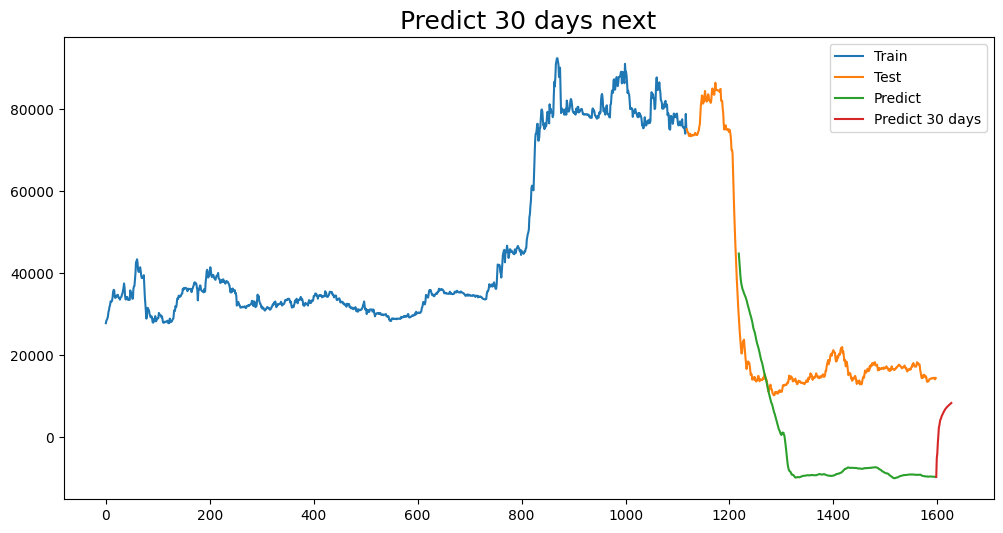

In [21]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 30 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index = np.arange(len(df1), len(df1) + 30)
plt.plot(future_data_index, lst_output, label='Predict 30 days')

plt.legend()
plt.show()

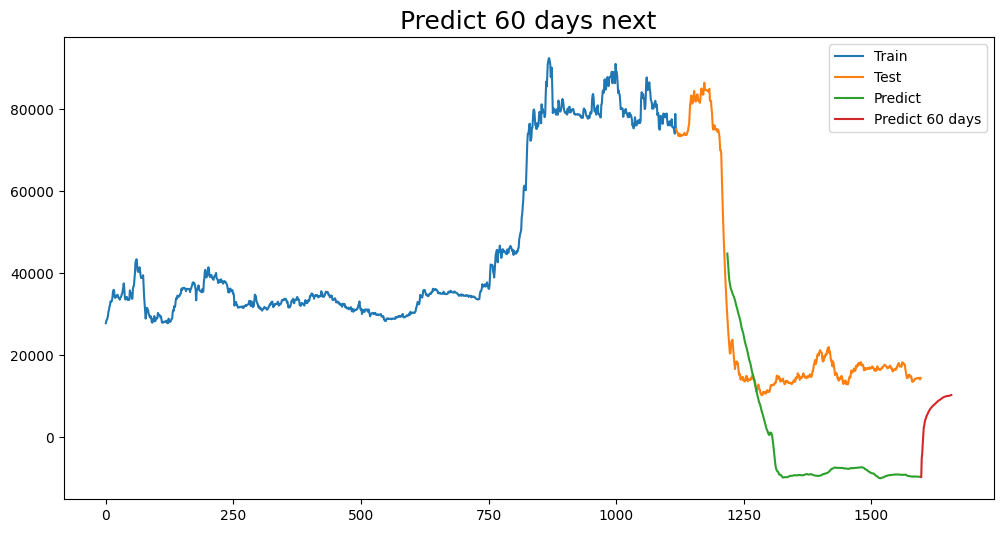

In [22]:
# Vẽ hình
plt.figure(figsize=(12, 6))
plt.title("Predict 60 days next", fontsize=18)
train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_60 = np.arange(len(df1), len(df1) + 60)
plt.plot(future_data_index_60, lst_output_60, label='Predict 60 days')

plt.legend()
plt.show()

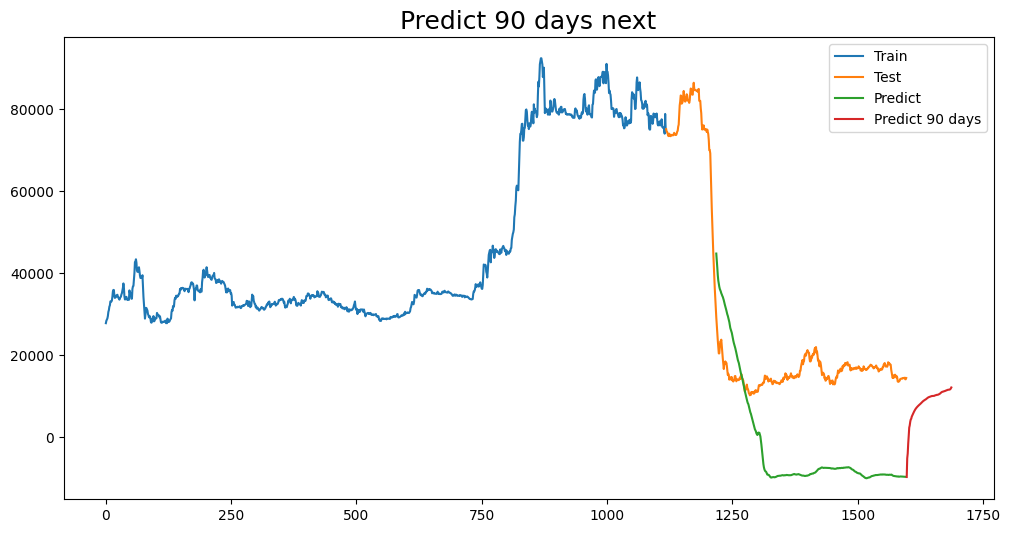

In [24]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1)-1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()

# Mô hình ResnetLSTM

In [25]:
# Định nghĩa mô hình ResNetLSTM
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNetLSTM(Module):
    def __init__(self, c_in, c_out, lstm_hidden_units=50, num_lstm_layers=1):
        super().__init__()
        nf = 64
        kss = [7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.lstm = nn.LSTM(nf * 2, lstm_hidden_units, num_lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = x.transpose(1, 2)  # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Lấy đầu ra của LSTM ở bước thời gian cuối cùng
        x = self.fc(x)
        return x

In [26]:
# Khởi tạo mô hình
model2 = ResNetLSTM(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [33]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model2.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model2.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model2(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 0.0013088976265862584, Test Loss: 0.00209769161301665
Epoch 2/100, Loss: 0.009797141887247562, Test Loss: 0.011817444659148654
Epoch 3/100, Loss: 0.014362547546625137, Test Loss: 0.016825690865516663
Epoch 4/100, Loss: 0.04005351662635803, Test Loss: 0.047016977022091545
Epoch 5/100, Loss: 0.054251883178949356, Test Loss: 0.060286606972416244
Epoch 6/100, Loss: 0.049954354763031006, Test Loss: 0.052976710721850395
Epoch 7/100, Loss: 0.05751814320683479, Test Loss: 0.060734822104374565
Epoch 8/100, Loss: 0.060738034546375275, Test Loss: 0.0640165942410628
Epoch 9/100, Loss: 0.06829774379730225, Test Loss: 0.0716413085659345
Epoch 10/100, Loss: 0.0774657353758812, Test Loss: 0.08071197755634785
Epoch 11/100, Loss: 0.06572325527667999, Test Loss: 0.06801069962481658
Epoch 12/100, Loss: 0.07095414400100708, Test Loss: 0.07436175644397736
Epoch 13/100, Loss: 0.07463065534830093, Test Loss: 0.07585708859066169
Epoch 14/100, Loss: 0.06618894636631012, Test Loss: 0.068320743

In [34]:
# Dự báo dữ liệu test
model2.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model2(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model2(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [35]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 23998.6308
Test MAPE: 164.0565%
Test MASE: 3778453.1206
Test MSE: 627723135.5903
Test RMSE: 25054.4035


In [36]:
# Dự báo 90 ngày tiếp theo
model2.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model2(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

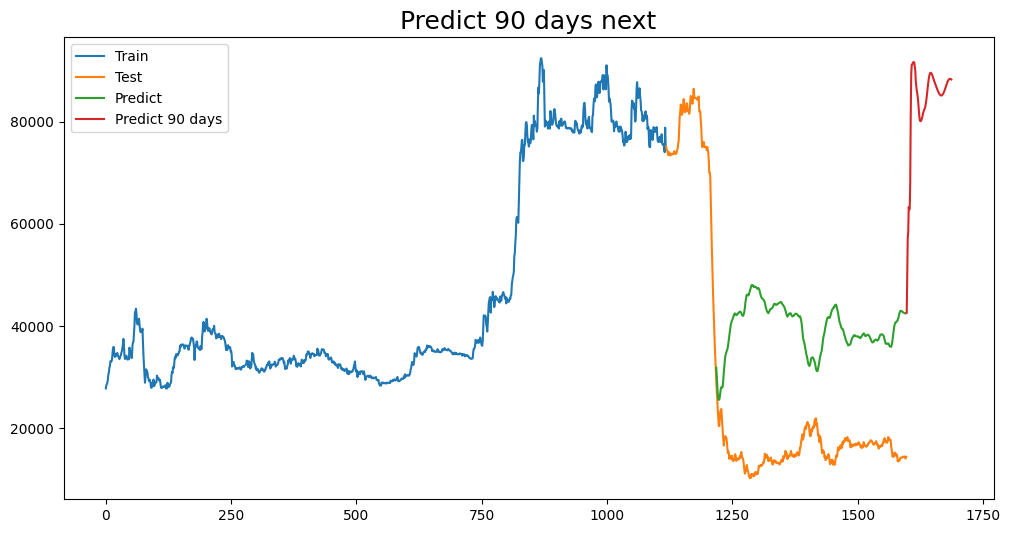

In [37]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()

# Điều chỉnh layer LSTM

In [38]:
# Định nghĩa mô hình ResNetLSTM
class ConvBlock(Module):
    def __init__(self, ni, nf, ks, stride=1, act=nn.ReLU, act_kwargs={}):
        super().__init__()
        self.conv = nn.Conv1d(ni, nf, ks, stride=stride, padding=ks//2)
        self.bn = nn.BatchNorm1d(nf)
        self.act = act(**act_kwargs) if act is not None else nn.Identity()

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResBlock(Module):
    def __init__(self, ni, nf, kss=[7, 5, 3]):
        super().__init__()
        self.convblock1 = ConvBlock(ni, nf, kss[0])
        self.convblock2 = ConvBlock(nf, nf, kss[1])
        self.convblock3 = ConvBlock(nf, nf, kss[2], act=None)

        self.shortcut = nn.BatchNorm1d(ni) if ni == nf else ConvBlock(ni, nf, 1, act=None)
        self.add = nn.Identity()
        self.act = nn.ReLU()

    def forward(self, x):
        res = x
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.add(x + self.shortcut(res))
        x = self.act(x)
        return x

class ResNetLSTM(Module):
    def __init__(self, c_in, c_out, lstm_hidden_units=150, num_lstm_layers=1, dropout=0.3): # hidden_units
        super().__init__()
        nf = 64
        kss = [7, 5, 3]
        self.resblock1 = ResBlock(c_in, nf, kss=kss)
        self.resblock2 = ResBlock(nf, nf * 2, kss=kss)
        self.resblock3 = ResBlock(nf * 2, nf * 2, kss=kss)

        self.lstm = nn.LSTM(nf * 2, lstm_hidden_units, num_lstm_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, c_out)

    def forward(self, x):
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = x.transpose(1, 2)  # Transpose for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Lấy đầu ra của LSTM ở bước thời gian cuối cùng
        x = self.fc(x)
        return x

In [39]:
# Khởi tạo mô hình
model3 = ResNetLSTM(1, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [40]:
# Huấn luyện mô hình
num_epochs = 100
for epoch in range(num_epochs):
    model3.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

    model3.eval()
    test_loss = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model3(inputs)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}, Test Loss: {test_loss}')


Epoch 1/100, Loss: 0.00031094514997676015, Test Loss: 0.0010042261371078591
Epoch 2/100, Loss: 0.00443504611030221, Test Loss: 0.005230654341479142
Epoch 3/100, Loss: 0.012161977589130402, Test Loss: 0.013474951963871717
Epoch 4/100, Loss: 0.015069536864757538, Test Loss: 0.020132921325663727
Epoch 5/100, Loss: 0.024868087843060493, Test Loss: 0.03218537506957849
Epoch 6/100, Loss: 0.025927165523171425, Test Loss: 0.034805476665496826
Epoch 7/100, Loss: 0.01600700244307518, Test Loss: 0.022231953994681437
Epoch 8/100, Loss: 0.024326903745532036, Test Loss: 0.03322288362930218
Epoch 9/100, Loss: 0.025952953845262527, Test Loss: 0.03613699382791916
Epoch 10/100, Loss: 0.026550360023975372, Test Loss: 0.03662831615656614
Epoch 11/100, Loss: 0.022614050656557083, Test Loss: 0.0323490792264541
Epoch 12/100, Loss: 0.028195174410939217, Test Loss: 0.04100019702066978
Epoch 13/100, Loss: 0.02033856138586998, Test Loss: 0.029106476499388616
Epoch 14/100, Loss: 0.02408096380531788, Test Loss: 0.

In [41]:
# Dự báo dữ liệu test
model3.eval()
train_predict = []
with torch.no_grad():
    for inputs, _ in train_loader:
        outputs = model3(inputs)
        train_predict.extend(outputs.squeeze().numpy())

test_predict = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model3(inputs)
        test_predict.extend(outputs.squeeze().numpy())

train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))

In [42]:
# Giá trị thực tế của tập huấn luyện và tập kiểm tra
y_train2 = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính độ đo cho tập kiểm tra
test_mae = mae(y_test2, test_predict)
test_mape = mape(y_test2, test_predict)
test_mase = mase(y_test2, test_predict, y_train)
test_mse = mse(y_test2, test_predict)
test_rmse = rmse(y_test2, test_predict)

print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')
print(f'Test MASE: {test_mase:.4f}')
print(f'Test MSE: {test_mse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Test MAE: 23033.4686
Test MAPE: 157.5654%
Test MASE: 3626493.6227
Test MSE: 584662255.4875
Test RMSE: 24179.7902


In [43]:
# Dự báo 90 ngày tiếp theo
model3.eval()
x_input = test_data[-100:].reshape(1, -1)
x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0)
temp_input = list(x_input[0, 0, :].numpy())
lst_output_90 = []

for i in range(90):
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        x_input = torch.tensor(x_input, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        yhat = model3(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        temp_input = temp_input[1:]
        lst_output_90.extend(yhat.detach().numpy().tolist())
    else:
        x_input = x_input.reshape((1, 1, time_step))
        yhat = model3(x_input)
        temp_input.extend(yhat[0].detach().numpy().tolist())
        lst_output_90.extend(yhat.detach().numpy().tolist())

lst_output_90 = scaler.inverse_transform(lst_output_90)

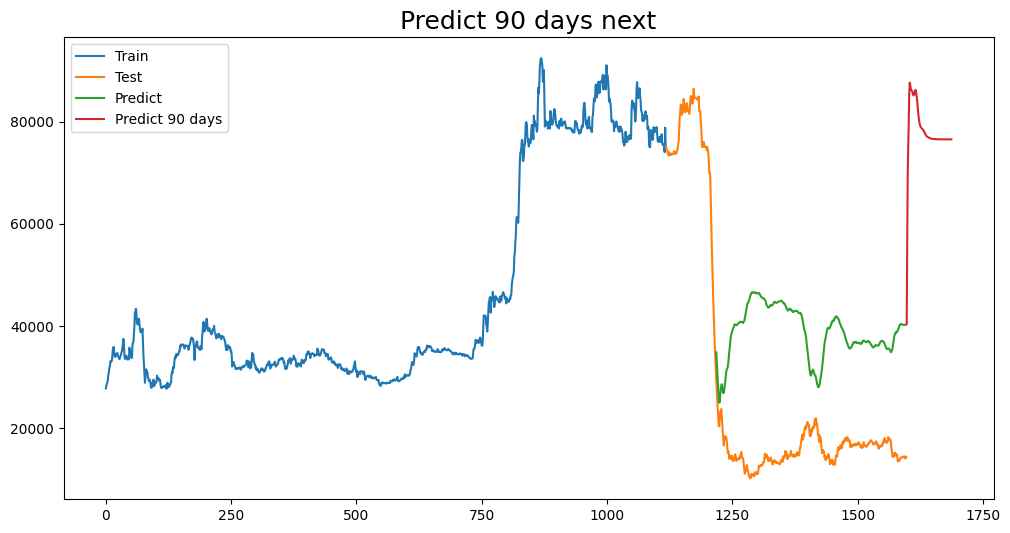

In [44]:
# Vẽ đồ thị
plt.figure(figsize=(12, 6))
plt.title("Predict 90 days next", fontsize=18)

train_data_index = np.arange(0, train_size)
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')

test_data_index = np.arange(train_size, len(df1))
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

pred_data_index = np.arange(train_size + time_step, len(df1) - 1)
plt.plot(pred_data_index, test_predict, label='Predict')

future_data_index_90 = np.arange(len(df1), len(df1) + 90)
plt.plot(future_data_index_90, lst_output_90, label='Predict 90 days')

plt.legend()
plt.show()